In [1]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
from dateutil.relativedelta import relativedelta
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import gc
gc.collect()

51

In [4]:
# Client & TPA

TPA = pd.read_excel('../data/Copy_of_TPA_cash.xlsx',sheet_name='Sheet1')
Client = pd.read_excel('../data/Client_info_20191118.xlsx',sheet_name='Sheet1')
# 3 Clients have duplicates records
# Client[Client['Client ID'].isin([1500,7601,2449])]
Client = Client.drop(Client.index[[0,1,497]])


Client = Client.merge(TPA,how='left',left_on='Client ID',right_on='HOST ID')
Client['TPA'] = Client['TPA_x']
Client.loc[Client['TPA_x'].isnull(),'TPA'] = Client.loc[Client['TPA_x'].isnull(),'TPA_y']
Client['TPA'] = Client['TPA'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Client.drop(['TPA_x','TPA_y','HOST ID'],axis=1,inplace = True)

In [5]:
### 1. Customer Dataset

Customer_old = pd.read_csv('../data/Customer_Data_Request_20191121.csv')
Customer = pd.read_csv('../data/Customer_Data_Request_20191217.csv')

# Append these 2 dataframes together
Customer = Customer_old.append(Customer,ignore_index = True)
# 2 Customer has duplicating records, we pick ClientID 2049 as their real Client but this is just a random choice
# Customer[Customer['Unique_Customer_ID']==100541023,100696306]
# Drop the duplicates customerID by index
Customer = Customer.drop(Customer.index[[72898,51730]])


# Some data cleaning here, eliminate the customers with following cases
# Customer_Salary has NaN, 0 and '.' ~11%
# Assigned_Spending_Limit has 0 ~7%
# Customer_Tenure has NaN

# Customer = Customer[(Customer['Assigned_Spending_Limit'] != 0) & 
#                     (~Customer['Customer_Salary'].isin([0, '.'])) & 
#                     (Customer['Customer_Salary'].notnull())&
#                     (Customer['Customer_Tenure'].notnull())]



 # Formating conversion
Customer['Street1'] = Customer['Street1'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['Street2'] = Customer['Street2'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['City'] = Customer['City'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['Status'] = Customer['Status'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer.loc[Customer['Customer_Salary']=='.','Customer_Salary']=np.nan
Customer['Customer_Salary'] = Customer['Customer_Salary'].astype(float)
Customer['Enrollment_Date'] = pd.to_datetime(Customer['Enrollment_Date'].astype(str), format='%m/%d/%Y')
Customer.loc[Customer['Term_Date']=='.','Term_Date'] = np.nan
Customer['Term_Date'] = pd.to_datetime(Customer['Term_Date'].astype(str), format='%m/%d/%Y')

Customer = Customer.merge(Client,how='left',left_on='Unique_Company_ID',right_on='Client ID')
Customer.head()

,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,100001115,1000,2014-02-24,6880.0,230.0,58229.0,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
1,100001120,1000,2014-02-24,6520.0,362.0,109245.0,Repeat Buyer,94 BRENTWOOD LN,NaN,VALLEY STREAM,NY,11581,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,100001141,1000,2014-02-25,10290.0,337.0,127226.0,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
3,100001158,1000,2014-02-24,5190.0,419.0,49375.0,Repeat Buyer,1036 BRADDISH AVE,NaN,BALTIMORE,MD,21216,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
4,100001169,1000,2014-02-24,7500.0,448.0,69460.0,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA


In [66]:
28605/Customer.shape[0]

0.04615548452367314

In [53]:
Customer[Customer['Assigned_Spending_Limit']==0].shape[0]/Customer.shape[0]

0.06992624481043254

In [55]:
Customer[Customer['Customer_Salary'].isin([0, '.'])].shape[0]/Customer.shape[0]

0.002521972463223252

In [199]:
Customer[Customer['Customer_Salary'].isnull()].shape[0]/Customer.shape[0]

0.1093887403530116

In [6]:
# 2. Performance Dataset

Perf_11 = pd.read_csv('../data/Performance_Data_Request_20191217.csv')
Perf = pd.read_csv('../data/Performance_Data_Request_20191204.csv')
# Deal with the column name mismatching issue before appending the 2 dataframes together
Perf_11.rename(columns={' Unique_Order_ID': 'Unique_Order_ID',
                        'Order_date': 'Order_Date'}, inplace=True)
Perf.rename(columns={'items_ordered': 'Items_Ordered',
                     'EMPSTATUS': 'Customer_Status'}, inplace=True)
Perf = Perf.append(Perf_11, ignore_index=True)

# Make sure the data order is aligned with OrderID & Y-M
Perf['Year_and_Month'] = pd.to_datetime(
    Perf['Year_and_Month'].astype(str), format='%Y%m')
Perf = Perf.sort_values(
    ['Unique_Order_ID', 'Year_and_Month'], ascending=[False, True])

# Create new column - YQ and Year
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
Perf['Year'] = Perf['YQ'].dt.year

Perf = Perf.replace('.', np.nan)


numeric_columns = ['Order_Amount', 'Product_Markup', 'Payments_Due', 'Current_Balance', 'Losses', 
                   'Spending_Limit_at_time_of_Order', 'Tenure_at_time_of_Order','Salary_at_time_of_Order']
Perf[numeric_columns] = Perf[numeric_columns].astype(float)


date_columns = ['Year_and_Month','Date_account_went_delinquent','Order_Date']

Perf[date_columns] = pd.to_datetime(Perf[date_columns].astype(str),format = '%m/%d/%Y' )


# Perf.loc[Perf['Date_account_went_delinquent']=='.','Date_account_went_delinquent'] = np.nan
Perf['Date_account_went_delinquent'] = pd.to_datetime(
    Perf['Date_account_went_delinquent'].astype(str), format='%m/%d/%Y')


# Perf.loc[Perf['Tenure_at_time_of_Order']=='.','Tenure_at_time_of_Order'] = np.nan
# Perf['Tenure_at_time_of_Order'] = Perf['Tenure_at_time_of_Order'].astype(float)

# Perf['Salary_at_time_of_Order'] = Perf['Salary_at_time_of_Order'].astype(float)


# Assign Payment Order as a new column
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')[
    'Year_and_Month'].rank(method='first')

# Treat 151+ ad CO as BAD
Perf['Bad'] = 0
Perf.loc[Perf['Default_Status'].isin(['151+', 'Chargeoff']), 'Bad'] = 1
# Create a flag Ever_Bad to distinguish first time bad and non-first time bad
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

# Create 2os Loss, using Losses for C/O orders and Current_Balance for 151+ orders
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status'] == 'Chargeoff',
         '2os_loss'] = Perf.loc[Perf['Default_Status'] == 'Chargeoff', 'Losses']
Perf.loc[Perf['Default_Status'] == '151+',
         '2os_loss'] = Perf.loc[Perf['Default_Status'] == '151+', 'Current_Balance']


# Perf['Enrollment_Date'] = pd.to_datetime(Perf['Enrollment_Date'].astype(str), format = '%m/%d/%Y')

# Some cleaning here
# Perf.loc[Perf['Order_Amount'] == '.', 'Order_Amount'] = np.nan
# Perf['Order_Amount'] = Perf['Order_Amount'].astype(float)

Perf = Perf[(Perf['Order_Amount'].notnull()) & (Perf['Order_Amount'] != 0)]

# Perf.loc[Perf['Payments_Due']=='.','Payments_Due']=np.nan
# Perf['Payments_Due'] = Perf['Payments_Due'].astype(float)


Perf = Perf.merge(Customer, how='left', on='Unique_Customer_ID')

In [200]:
Perf.head()

,Unique_Order_ID,Unique_Customer_ID,Order_Amount,Product_Markup,Payments_Due,Current_Balance,Date_account_went_delinquent,Default_Status,Delinquency_Bucket,Losses,Auto_Pay_Enrollment,Order_Closed_Flag,Type_of_Backup_Payment,Spending_Limit_at_time_of_Order,Tenure_at_time_of_Order,Salary_at_time_of_Order,Street1_x,Street2_x,City_x,State_x,Zip_x,Items_Ordered,Year_and_Month,Customer_Status,Order_Date,YQ,Year,Payment_Order,Bad,Ever_Bad,2os_loss,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1_y,Street2_y,City_y,State_y,Zip_y,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,YCCZIMM1449606,173585108,349.57,.,6.72,336.00,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-01-01,Employed,01/17/2014,2014Q1,2014,1.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
1,YCCZIMM1449606,173585108,349.57,.,6.72,309.12,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-02-01,Employed,01/17/2014,2014Q1,2014,2.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
2,YCCZIMM1449606,173585108,349.57,.,6.72,282.24,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-03-01,Employed,01/17/2014,2014Q1,2014,3.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
3,YCCZIMM1449606,173585108,349.57,.,6.72,248.64,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-04-01,Employed,01/17/2014,2014Q2,2014,4.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
4,YCCZIMM1449606,173585108,349.57,.,6.72,221.76,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146.0,28308.8,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-05-01,Employed,01/17/2014,2014Q2,2014,5.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX


### Data Questions

In [7]:
Perf.shape[0]

38857220

 - Tenure_at_time_of_Order vs Customer_Tenure

In [ ]:
# ---------------------------------------------------------------------------------------------------- # 
# Order that have more than 1 unique Tenure_at_time_of_Order, or more than 1 Customer_Tenure

In [27]:
x = Perf.groupby('Unique_Order_ID').agg({'Tenure_at_time_of_Order':'nunique','Customer_Tenure':'nunique'}).reset_index()

In [28]:
x[x['Tenure_at_time_of_Order']>1]

,Unique_Order_ID,Tenure_at_time_of_Order,Customer_Tenure
2699955,27837322,2,1
2711575,27921169,2,1
2721707,28010392,2,1
2736607,28098591,2,1
2743269,28167930,2,1
2745293,28186442,2,1


In [12]:
x[x['Customer_Tenure']>1]

,Unique_Order_ID,Tenure_at_time_of_Order,Customer_Tenure
2384907,25724397,1,2


In [ ]:
# ---------------------------------------------------------------------------------------------------- # 

In [34]:
Perf[Perf['Unique_Order_ID']==28186442][['Unique_Order_ID','Unique_Customer_ID','Tenure_at_time_of_Order','Customer_Tenure']]

,Unique_Order_ID,Unique_Customer_ID,Tenure_at_time_of_Order,Customer_Tenure
6236641,28186442,307908601,14.0,15.0
6236642,28186442,307908601,130.0,15.0


In [36]:
T = Perf.groupby('Unique_Order_ID')[['Unique_Order_ID','Unique_Customer_ID','Tenure_at_time_of_Order','Customer_Tenure']].head(1)

In [37]:
T.shape

(3291432, 4)

In [40]:
T.head()

,Unique_Order_ID,Unique_Customer_ID,Tenure_at_time_of_Order,Customer_Tenure
0,YCCZIMM1449606,173585108,146.0,146.0
22,YCCZIMM1404330,173585108,146.0,146.0
45,YCCZIMM1281194,173585108,146.0,146.0
66,YCCZIMM1088572,173585108,146.0,146.0
78,YCCYATE993172,174315078,154.0,154.0


In [41]:
T[T['Tenure_at_time_of_Order']==T['Customer_Tenure']].shape

(2417760, 4)

In [47]:
T[(T['Tenure_at_time_of_Order'].isnull()) & (T['Customer_Tenure'].isnull())].shape[0]

236

In [48]:
(2417760+236)/3291432

0.7346334361457262

In [46]:
T['diff'] = T['Customer_Tenure'] - T['Tenure_at_time_of_Order']
# T[T['Tenure_at_time_of_Order']!=T['Customer_Tenure']]
T[T['diff']==1].shape[0]/T.shape[0]

0.023689385045779467

In [54]:
# T[(~T['diff'].isin([0,1])) & (T['diff'].notnull())]

In [53]:
T[T['diff']<0]#.shape[0]

,Unique_Order_ID,Unique_Customer_ID,Tenure_at_time_of_Order,Customer_Tenure,diff
6140411,28930066,304715805,51.0,34.0,-17.0
6140775,28926116,301497294,125.0,122.0,-3.0
6140908,28924084,301582061,40.0,39.0,-1.0
6140974,28922219,247816005,78.0,21.0,-57.0
6141142,28920306,301571768,44.0,41.0,-3.0
6141244,28918236,308377759,412.0,17.0,-395.0
6141367,28917173,305106863,54.0,44.0,-10.0
6141524,28906654,308417084,54.0,43.0,-11.0
6141552,28906490,308522055,181.0,62.0,-119.0
6142341,28894229,302904024,68.0,61.0,-7.0


In [52]:
8150/3291432

0.002476125892924417

- Salary_at_time_of_Order vs Customer_Salary

In [57]:
# Perf.loc[Perf['Salary_at_time_of_Order'] == '.','Salary_at_time_of_Order'] = np.nan
# Perf['Salary_at_time_of_Order'] = Perf['Salary_at_time_of_Order'].astype(float)

In [58]:
Perf[['Salary_at_time_of_Order','Customer_Salary']].dtypes

Salary_at_time_of_Order    float64
Customer_Salary            float64
dtype: object

In [59]:
x = Perf.groupby('Unique_Order_ID').agg({'Salary_at_time_of_Order':'nunique','Customer_Salary':'nunique'}).reset_index()

In [60]:
x[x['Salary_at_time_of_Order']>1]

,Unique_Order_ID,Salary_at_time_of_Order,Customer_Salary
2697497,27820129,2,1
2699750,27836631,2,1
2699955,27837322,2,1
2700674,27845353,2,1
2701217,27846948,2,1
2703435,27855596,2,1
2704605,27859039,2,1
2705309,27863177,2,1
2711575,27921169,2,1
2714406,27947691,2,1


In [61]:
x[x['Customer_Salary']>1]

,Unique_Order_ID,Salary_at_time_of_Order,Customer_Salary
2167076,24179952,0,2
2384907,25724397,0,2
2432995,26198057,1,2
2570909,27194532,1,2


In [ ]:
Perf[Perf['Unique_Order_ID']==26198057][['Unique_Order_ID','Unique_Customer_ID','Salary_at_time_of_Order','Customer_Salary','Tenure_at_time_of_Order','Customer_Tenure']]

In [72]:
S = Perf.groupby('Unique_Order_ID')[['Unique_Order_ID','Unique_Customer_ID','Salary_at_time_of_Order','Customer_Salary','Tenure_at_time_of_Order','Customer_Tenure']].head(1)

In [73]:
S.head()

,Unique_Order_ID,Unique_Customer_ID,Salary_at_time_of_Order,Customer_Salary,Tenure_at_time_of_Order,Customer_Tenure
0,YCCZIMM1449606,173585108,28308.8,28308.8,146.0,146.0
22,YCCZIMM1404330,173585108,28308.8,28308.8,146.0,146.0
45,YCCZIMM1281194,173585108,28308.8,28308.8,146.0,146.0
66,YCCZIMM1088572,173585108,28308.8,28308.8,146.0,146.0
78,YCCYATE993172,174315078,28163.2,28163.2,154.0,154.0


In [93]:
S[np.abs(S['diff'])<1].shape[0]/S.shape[0]

0.42973909228566776

In [74]:
S[S['Salary_at_time_of_Order']==S['Customer_Salary']].shape[0]/S.shape[0]

0.41740980825367197

In [77]:
S[(S['Salary_at_time_of_Order'].isnull()) & (S['Customer_Salary'].isnull())].shape[0]/S.shape[0]

0.06768239477528322

In [92]:
S['diff'] = S['Customer_Salary'] - S['Salary_at_time_of_Order']
S['100s'] = S['Salary_at_time_of_Order']*100
S['100diff'] = S['Customer_Salary'] - S['100s']

In [97]:
S[np.abs(S['100diff'])<1].shape[0]/S.shape[0]

0.38345984361821844

In [88]:
S[S['100s']==S['Customer_Salary']].shape[0]/S.shape[0]

0.34318983348281235

In [94]:
S[(S['Salary_at_time_of_Order']!=S['Customer_Salary'])&(S['diff']!=0)&(np.abs(S['diff'])>1)&(np.abs(S['100diff'])>1)&(S['Salary_at_time_of_Order'].notnull())]

,Unique_Order_ID,Unique_Customer_ID,Salary_at_time_of_Order,Customer_Salary,Tenure_at_time_of_Order,Customer_Tenure,100s,diff,100diff
6140091,28947200,301307371,29540.16,2.860416e+04,61.0,61.0,2954016.0,-9.360000e+02,-2.925412e+06
6140096,28947059,307625059,34999.99,2.999999e+04,21.0,21.0,3499999.0,-5.000000e+03,-3.469999e+06
6140097,28946284,305592016,49226.67,4.836000e+04,55.0,55.0,4922667.0,-8.666700e+02,-4.874307e+06
6140101,28946055,100261379,67902.28,6.624613e+04,214.0,214.0,6790228.0,-1.656150e+03,-6.723982e+06
6140116,28943094,307851786,35880.00,3.224000e+04,36.0,36.0,3588000.0,-3.640000e+03,-3.555760e+06
6140134,28938393,305105672,25188.80,2.431520e+04,35.0,35.0,2518880.0,-8.736000e+02,-2.494565e+06
6140138,28938307,305003559,35435.40,3.543150e+04,60.0,60.0,3543540.0,-3.900000e+00,-3.508108e+06
6140142,28938254,307948154,4451200.00,4.451200e+04,20.0,20.0,445120000.0,-4.406688e+06,-4.450755e+08
6140150,28938119,304172753,41507.68,4.069380e+04,204.0,204.0,4150768.0,-8.138800e+02,-4.110074e+06
6140155,28938050,100604009,66841.80,6.514800e+04,170.0,170.0,6684180.0,-1.693800e+03,-6.619032e+06


In [95]:
325205/S.shape[0]

0.09880349951024357

In [98]:
43+7+38+10

98

- Order Amount vs Current Balance

In [99]:
B = Perf.groupby('Unique_Order_ID')[['Unique_Order_ID','Unique_Customer_ID','Default_Status','Order_Amount','Current_Balance','Payments_Due','Year_and_Month','Payment_Order']].head(1)

In [110]:
B.head()

,Unique_Order_ID,Unique_Customer_ID,Default_Status,Order_Amount,Current_Balance,Payments_Due,Year_and_Month,Payment_Order,num_of_pay
0,YCCZIMM1449606,173585108,Current,349.57,336.00,6.72,2014-01-01,1.0,2.019345
22,YCCZIMM1404330,173585108,Current,333.05,320.00,6.40,2013-12-01,1.0,2.039063
45,YCCZIMM1281194,173585108,Current,560.49,560.04,10.77,2013-08-01,1.0,0.041783
66,YCCZIMM1088572,173585108,Current,339.07,339.04,6.52,2012-12-01,1.0,0.004601
78,YCCYATE993172,174315078,Current,2018.74,2018.64,38.82,2012-08-01,1.0,0.002576


In [101]:
(349.57-336)/6.72

2.0193452380952372

In [102]:
B[B['Current_Balance']==0].shape[0]/B.shape[0]

0.0218768001283332

In [127]:
B[B['Current_Balance']==0]

,Unique_Order_ID,Unique_Customer_ID,Default_Status,Order_Amount,Current_Balance,Payments_Due,Year_and_Month,Payment_Order,num_of_pay
25995,WINSAND1481683,100762928,Current,49.00,0.0,8.62,2015-10-01,1.0,5.684455
45596,WINLEE1209781,100267952,Current,489.10,0.0,9.40,2013-04-01,1.0,52.031915
51162,WINHUTC1003211,100496021,Current,2335.80,0.0,44.91,2013-04-01,1.0,52.010688
55954,WINGUTI1312498,100645935,Current,425.99,0.0,8.19,2013-09-01,1.0,52.013431
80090,WINANGL1125711,100173543,Current,493.06,0.0,9.48,2013-11-01,1.0,52.010549
85182,WELWHIT1085778,100237018,Current,480.43,0.0,18.47,2013-11-01,1.0,26.011370
86020,WELWASH1082128,134626877,Current,700.84,0.0,26.95,2013-11-01,1.0,26.005195
91752,WELSMIT1062341,100406841,Current,465.45,0.0,17.90,2013-11-01,1.0,26.002793
126680,WELBERR1280649,100242659,Current,78.96,0.0,3.04,2013-08-01,1.0,25.973684
176367,VENGUEV1103491,196743155,Current,1867.68,0.0,71.83,2013-11-01,1.0,26.001392


In [132]:
Perf[Perf['Unique_Order_ID'].isin(B[B['Current_Balance']==0]['Unique_Order_ID'].tolist())].groupby('Unique_Order_ID').size().sort_values()

Unique_Order_ID
10170589          1
21655000          1
21655079          1
21655092          1
21655093          1
21655097          1
21655765          1
21655787          1
21655793          1
21655794          1
21655809          1
21655810          1
21655812          1
21655820          1
21656068          1
21656104          1
21656724          1
21656735          1
21661548          1
21661546          1
21661529          1
21661511          1
21660586          1
21660585          1
21651040          1
21660581          1
21659586          1
21659579          1
21659575          1
21659560          1
21656775          1
21656744          1
21659591          1
21661551          1
21651037          1
21650091          1
21636770          1
21636772          1
21636773          1
21637054          1
21637112          1
21637140          1
21638005          1
21638028          1
21638109          1
21639015          1
21647044          1
21647093          1
21647131          1
2164

In [147]:
Perf[Perf['Unique_Order_ID']=='YCCNEWB1030030'][['Unique_Order_ID','Unique_Customer_ID','Default_Status','Order_Amount','Current_Balance','Payments_Due','Year_and_Month','Payment_Order']]

,Unique_Order_ID,Unique_Customer_ID,Default_Status,Order_Amount,Current_Balance,Payments_Due,Year_and_Month,Payment_Order
2558,YCCNEWB1030030,173812535,Current,1491.43,1614.66,31.66,2012-09-01,1.0
2559,YCCNEWB1030030,173812535,Current,1491.43,1333.02,31.66,2012-10-01,2.0
2560,YCCNEWB1030030,173812535,Current,1491.43,1206.38,31.66,2012-11-01,3.0
2561,YCCNEWB1030030,173812535,001-030,1491.43,1206.38,31.66,2012-12-01,4.0
2562,YCCNEWB1030030,173812535,Current,1491.43,953.10,31.66,2013-01-01,5.0
2563,YCCNEWB1030030,173812535,001-030,1491.43,953.10,31.66,2013-02-01,6.0
2564,YCCNEWB1030030,173812535,Current,1491.43,668.16,31.66,2013-03-01,7.0
2565,YCCNEWB1030030,173812535,Current,1491.43,541.52,31.66,2013-04-01,8.0
2566,YCCNEWB1030030,173812535,Current,1491.43,414.88,31.66,2013-05-01,9.0
2567,YCCNEWB1030030,173812535,001-030,1491.43,414.88,31.66,2013-06-01,10.0


In [105]:
B[B['Current_Balance']>B['Order_Amount']].shape[0]/B.shape[0]

0.020274154228311567

In [143]:
B[B['Current_Balance']>B['Order_Amount']]

,Unique_Order_ID,Unique_Customer_ID,Default_Status,Order_Amount,Current_Balance,Payments_Due,Year_and_Month,Payment_Order,num_of_pay
126,YCCWRIG1470231,194295619,Current,40.00,1134.12,21.81,2014-02-01,1.0,-50.165979
1803,YCCSAWY1431311,193166058,Current,232.19,369.24,7.24,2013-12-01,1.0,-18.929558
2558,YCCNEWB1030030,173812535,Current,1491.43,1614.66,31.66,2012-09-01,1.0,-3.892293
3568,YCCKIMB1098188,173882710,Current,324.59,344.24,6.62,2012-11-01,1.0,-2.968278
3581,YCCKIMB1073477,173882710,Current,344.56,364.52,7.01,2012-11-01,1.0,-2.847361
4574,YCCFUSS1334716,173159532,Current,184.74,1039.48,19.99,2013-10-01,1.0,-42.758379
4808,YCCENSM1404388,173887716,Current,450.19,653.00,13.06,2013-12-01,1.0,-15.529096
5113,YCCCUMM1371595,188949046,Current,273.25,1066.52,20.51,2013-11-01,1.0,-38.677231
5828,YCCCALC1258690,175033084,Current,2021.36,2101.32,40.41,2013-07-01,1.0,-1.978718
7575,WYFSMIT1468988,247608889,Current,493.88,2158.80,89.95,2014-02-01,1.0,-18.509394


In [111]:
B['num_of_pay'] = (B['Order_Amount'] - B['Current_Balance'])/B['Payments_Due']
# B['num_of_pay'] = B['num_of_pay'].astype(int)

In [119]:
B[(B['num_of_pay']>=0)&(B['num_of_pay']<5)].shape[0]/B.shape[0]

0.9182841997039587

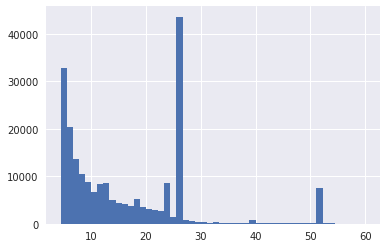

In [126]:
B[(B['num_of_pay']>4.5)&(B['num_of_pay']<60)]['num_of_pay'].hist(bins=50)

In [142]:
Perf[['Unique_Order_ID','Unique_Customer_ID','Default_Status','Order_Amount','Current_Balance','Payments_Due','Year_and_Month','Payment_Order']].head(200)

,Unique_Order_ID,Unique_Customer_ID,Default_Status,Order_Amount,Current_Balance,Payments_Due,Year_and_Month,Payment_Order
0,YCCZIMM1449606,173585108,Current,349.57,336.00,6.72,2014-01-01,1.0
1,YCCZIMM1449606,173585108,Current,349.57,309.12,6.72,2014-02-01,2.0
2,YCCZIMM1449606,173585108,Current,349.57,282.24,6.72,2014-03-01,3.0
3,YCCZIMM1449606,173585108,Current,349.57,248.64,6.72,2014-04-01,4.0
4,YCCZIMM1449606,173585108,Current,349.57,221.76,6.72,2014-05-01,5.0
5,YCCZIMM1449606,173585108,Current,349.57,194.88,6.72,2014-06-01,6.0
6,YCCZIMM1449606,173585108,001-030,349.57,174.72,6.72,2014-07-01,7.0
7,YCCZIMM1449606,173585108,001-030,349.57,168.00,6.72,2014-08-01,8.0
8,YCCZIMM1449606,173585108,031-060,349.57,168.00,6.72,2014-09-01,9.0
9,YCCZIMM1449606,173585108,091-120,349.57,168.00,6.72,2014-10-01,10.0


In [195]:
C = Perf.groupby(['Unique_Customer_ID','Year_and_Month']).agg({'Unique_Order_ID':'nunique'}).reset_index()

In [196]:
C.sort_values(by='Unique_Order_ID',ascending=False)

,Unique_Customer_ID,Year_and_Month,Unique_Order_ID
14402165,302600003,2019-09-01,80
6396313,191936042,2018-12-01,80
10235447,300435805,2018-11-01,80
14402167,302600003,2019-11-01,77
10209384,300429634,2019-08-01,76
10209383,300429634,2019-07-01,76
10235453,300435805,2019-05-01,75
10235448,300435805,2018-12-01,75
10235449,300435805,2019-01-01,75
10235450,300435805,2019-02-01,75


In [198]:
Perf[Perf['Unique_Customer_ID']==302600003][['Unique_Order_ID','Unique_Customer_ID','Default_Status','Order_Amount','Current_Balance','Payments_Due','Year_and_Month','Payment_Order']].sort_values(['Unique_Order_ID','Year_and_Month'])

,Unique_Order_ID,Unique_Customer_ID,Default_Status,Order_Amount,Current_Balance,Payments_Due,Year_and_Month,Payment_Order
16604079,19220110,302600003,Current,647.13,520.03,24.89,2018-02-01,1.0
16604080,19220110,302600003,Current,647.13,463.02,24.89,2018-03-01,2.0
16604081,19220110,302600003,Current,647.13,412.73,24.89,2018-04-01,3.0
16604082,19220110,302600003,Current,647.13,361.01,24.89,2018-05-01,4.0
16604083,19220110,302600003,Current,647.13,319.93,24.89,2018-06-01,5.0
16604084,19220110,302600003,Current,647.13,279.91,24.89,2018-07-01,6.0
16604085,19220110,302600003,Current,647.13,219.88,24.89,2018-08-01,7.0
16604086,19220110,302600003,Current,647.13,179.86,24.89,2018-09-01,8.0
16604087,19220110,302600003,Current,647.13,139.84,24.89,2018-10-01,9.0
16604088,19220110,302600003,Current,647.13,99.82,24.89,2018-11-01,10.0


In [187]:
x = Perf.groupby('Unique_Order_ID')['Unique_Order_ID','Order_Amount','Spending_Limit_at_time_of_Order','Assigned_Spending_Limit'].head(1)

In [188]:
x.loc[x['Spending_Limit_at_time_of_Order']=='.','Spending_Limit_at_time_of_Order'] = np.nan
x['Spending_Limit_at_time_of_Order'] = x['Spending_Limit_at_time_of_Order'].astype(float)

In [189]:
x['100_limit'] = x['Spending_Limit_at_time_of_Order']*100

In [190]:
x['100_limit']  = x['100_limit'].apply(lambda x: int(x) if pd.notnull(x) else x)

In [191]:
x['Assigned_Spending_Limit']  = x['Assigned_Spending_Limit'].apply(lambda x: int(x) if pd.notnull(x) else x)

In [192]:
x['diff'] = x['Assigned_Spending_Limit'] - x['100_limit']

In [196]:
x[np.abs(x['diff'])<2].shape[0]

2808017

In [229]:
2808017/3291432

0.8531292762542261

In [230]:
233728/3291432

0.07101103714128075

In [136]:
x.shape

(3291432, 3)

In [100]:
Perf['Payments_Due'].isnull().sum()

0

In [101]:
Perf[Perf['Payments_Due']==0].shape[0]#/Perf.shape[0]

101

In [102]:
Perf[Perf['Payments_Due']=='.'].shape[0]#/Perf.shape[0]

8658

In [88]:
Perf[Perf['Date_account_went_delinquent']!='.']['Default_Status'].value_counts(dropna=False)

Current       3640977
151+          1482580
001-030       1135409
031-060        833766
061-090        595251
091-120        492177
121-150        434621
Chargeoff      357418
Bankruptcy     198702
Fraud           21424
Name: Default_Status, dtype: int64

In [12]:
# list(Perf)

In [11]:
Perf[['Unique_Order_ID','Unique_Customer_ID','Tenure_at_time_of_Order','Customer_Tenure']]

,Unique_Order_ID,Tenure_at_time_of_Order,Customer_Tenure
0,YCCZIMM1449606,146,146.0
1,YCCZIMM1449606,146,146.0
2,YCCZIMM1449606,146,146.0
3,YCCZIMM1449606,146,146.0
4,YCCZIMM1449606,146,146.0
5,YCCZIMM1449606,146,146.0
6,YCCZIMM1449606,146,146.0
7,YCCZIMM1449606,146,146.0
8,YCCZIMM1449606,146,146.0
9,YCCZIMM1449606,146,146.0


In [13]:
Perf[['Unique_Order_ID','Unique_Customer_ID','Tenure_at_time_of_Order','Customer_Tenure']].dtypes

Unique_Order_ID             object
Unique_Customer_ID           int64
Tenure_at_time_of_Order     object
Customer_Tenure            float64
dtype: object

In [15]:
Perf.loc[Perf['Tenure_at_time_of_Order']=='.','Tenure_at_time_of_Order'] = np.nan
Perf['Tenure_at_time_of_Order'] = Perf['Tenure_at_time_of_Order'].astype(float)

In [43]:
list(Perf[Perf['Tenure_at_time_of_Order'].isnull()]['Unique_Customer_ID'].unique())

40992

In [44]:
Customer.shape[0]

619753

In [46]:
Customer[Customer['Customer_Tenure'].isnull()].shape

(110, 31)

In [47]:
Perf['Unique_Customer_ID'].isnull().any()

False

In [42]:
Perf.shape[0]

38857220

In [18]:
x = Perf[Perf['Tenure_at_time_of_Order']!=Perf['Customer_Tenure']][['Unique_Order_ID','Unique_Customer_ID','Tenure_at_time_of_Order','Customer_Tenure']]

In [20]:
x.shape

(7209811, 4)

In [21]:
Perf.shape

(38857220, 61)

In [22]:
7209811/38857220

0.1855462382537917

In [23]:
x['Unique_Customer_ID'].nunique()

273207

In [24]:
t = Perf.groupby('Unique_Customer_ID').agg({'Tenure_at_time_of_Order':'nunique'}).reset_index()

In [25]:
t.head()

,Unique_Customer_ID,Tenure_at_time_of_Order
0,100001115,1
1,100001120,9
2,100001141,1
3,100001158,1
4,100001169,3


In [26]:
t[t['Tenure_at_time_of_Order']>1].shape

(204397, 2)

In [27]:
t.shape[0]

619481

In [148]:
#Select Performance Data after 2015
df_15 = Perf[Perf['Year']>=2015]

In [149]:
df_15['2os_bal'] = df_15['Current_Balance']
df_15.loc[df_15['Ever_Bad']>=1,'2os_bal']=0

In [161]:
df_15['2os_bal'] = df_15['Current_Balance']
df_15.loc[df_15['Default_Status'] == 'Chargeoff',
          '2os_bal'] = df_15.loc[df_15['Default_Status'] == 'Chargeoff', 'Losses']
df_15.loc[(df_15['Default_Status'] == 'Chargeoff') & (df_15['Losses'] == 0),
          '2os_bal'] = df_15.loc[df_15['Default_Status'] == 'Chargeoff', 'Current_Balance']
# df_15.loc[(df_15['Payment_Order'] == 1), '2os_bal'] = df_15.loc[(
#     df_15['Payment_Order'] == 1), 'Order_Amount']

In [150]:
# Monthly flow-in loss
d1 = df_15[(df_15['Bad']==1)&(df_15['Ever_Bad']<=1)].groupby('Year_and_Month').agg({'2os_loss':'sum'}).reset_index()

In [162]:
# Monthly balance of active accounts
d2 = df_15.groupby('Year_and_Month').agg({'2os_bal':'sum'}).reset_index()

In [163]:
# Merge these two by `Year and Month`
d3 = d1.merge(d2, how='left', on='Year_and_Month')

In [166]:
d3['loss_rate'] = (d3['2os_loss']/d3['2os_bal'])*12
d3['Year']=d3['Year_and_Month'].dt.year
d3

,Year_and_Month,2os_loss,2os_bal,loss_rate,Year
0,2015-01-01,1534316.62,1.975658e+08,0.093193,2015
1,2015-02-01,1318131.52,1.884952e+08,0.083915,2015
2,2015-03-01,1532162.89,1.829666e+08,0.100488,2015
3,2015-04-01,1309643.19,1.778114e+08,0.088384,2015
4,2015-05-01,1365530.15,1.734438e+08,0.094477,2015
5,2015-06-01,1600372.25,1.708581e+08,0.112400,2015
6,2015-07-01,1976183.22,1.692275e+08,0.140132,2015
7,2015-08-01,1994903.70,1.723383e+08,0.138906,2015
8,2015-09-01,2014090.87,1.690944e+08,0.142933,2015
9,2015-10-01,1888123.44,1.667046e+08,0.135914,2015


In [167]:
d3.groupby('Year').agg({'loss_rate':'mean'}).reset_index()

,Year,loss_rate
0,2015,0.112412
1,2016,0.118614
2,2017,0.124126
3,2018,0.132089
4,2019,0.159047


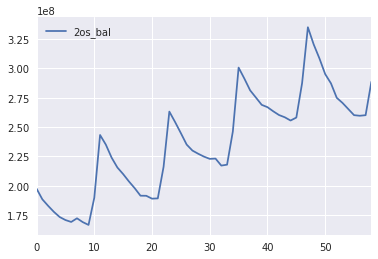

In [172]:
d3[['2os_bal']].plot()

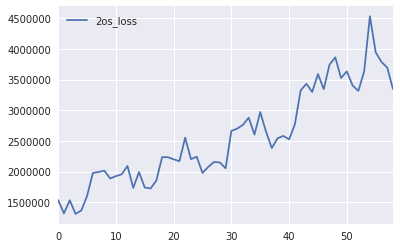

In [170]:
d3[['2os_loss']].plot()

In [173]:
d15 = df_15[(df_15['Year']==2015)&(df_15['Payment_Order']==1)]

In [175]:
d15.groupby('Year_and_Month').size()

Year_and_Month
2015-01-01    18042
2015-02-01    14236
2015-03-01    20227
2015-04-01    19718
2015-05-01    20109
2015-06-01    23153
2015-07-01    26646
2015-08-01    28515
2015-09-01    24348
2015-10-01    24375
2015-11-01    51867
2015-12-01    94895
dtype: int64

In [180]:
dd15 = df_15[df_15['Unique_Order_ID'].isin(d15['Unique_Order_ID'].tolist())]#.groupby('Unique_Order_ID')['Year_and_Month'].max()

In [181]:
dd15.head()

,Unique_Order_ID,Unique_Customer_ID,Order_Amount,Product_Markup,Payments_Due,Current_Balance,Date_account_went_delinquent,Default_Status,Delinquency_Bucket,Losses,Auto_Pay_Enrollment,Order_Closed_Flag,Type_of_Backup_Payment,Spending_Limit_at_time_of_Order,Tenure_at_time_of_Order,Salary_at_time_of_Order,Street1_x,Street2_x,City_x,State_x,Zip_x,Items_Ordered,Year_and_Month,Customer_Status,Order_Date,YQ,Year,Payment_Order,Bad,Ever_Bad,2os_loss,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1_y,Street2_y,City_y,State_y,Zip_y,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA,2os_bal
25995,WINSAND1481683,100762928,49.00,.,8.62,0.0,NaT,Current,000-000,0.0,PD,Y,ACH,39.25,130.0,34999.99,8000 LOTT RD,NaN,WILMER,AL,36587.0,NaN,2015-10-01,Employed,03/13/2014,2015Q4,2015,1.0,0,0,0.0,2181.0,2014-02-24,3925.0,130.0,34999.99,Repeat Buyer,21 ELM ST,NaN,SARALAND,AL,36571,TERMINATED,2016-12-05,Y,2181.0,SOUTHEASTERN GROCERS,12718.0,18256.0,Retail Trade,445120.0,Convenience Stores,Mercer - Atlanta,2007-11-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN,0.0
246587,USMDEER1481180,236105471,25.00,.,10.65,0.0,NaT,Current,000-000,0.0,PD,Y,ACH,0,99.0,NaN,2702 46TH ST,APT A,LUBBOCK,TX,79413.0,NaN,2015-10-01,Employed,03/12/2014,2015Q4,2015,1.0,0,0,0.0,8999.0,2014-02-25,0.0,99.0,NaN,Repeat Buyer,2702 46TH ST,APT A,LUBBOCK,TX,79413,EMPLOYED,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1614500,RITHAYE1457830,256172098,75.00,.,34.65,0.0,NaT,Current,000-000,0.0,PD,Y,ACH,27.85,110.0,22068.80,205 GEISER AVE,NaN,WAYNESBORO,PA,17268.0,Catnapper Top Gun Media Chaise Power Recliner-...,2015-10-01,Employed,01/31/2014,2015Q4,2015,1.0,0,0,0.0,2164.0,2014-02-24,2785.0,110.0,22068.80,First Time Byer,205 GEISER AVE,NaN,WAYNESBORO,PA,17268,EMPLOYED,NaT,Y,2164.0,RITE-AID,36833.0,66676.0,Retail Trade,446110.0,Pharmacies and Drug Stores,Perks Group / Augeo Affinity Insurance Service...,2005-11-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN,0.0
1894708,OHIMILL1465788,100521980,25.00,.,53.31,0.0,NaT,Current,000-000,0.0,PD,Y,ACH,29.7,193.0,210.00,11091 SCHWEIGHART RD,NaN,WINCHESTER,OH,45697.0,Apple MacBook Air 13.3in Display 4GB Memory La...,2015-10-01,Employed,02/14/2014,2015Q4,2015,1.0,0,0,0.0,2184.0,2014-02-24,2970.0,193.0,21000.00,Repeat Buyer,11091 SCHWEIGHART RD,NaN,WINCHESTER,OH,45697,EMPLOYED,NaT,Y,2184.0,OHIO CIVIL SERVICE EMPLOYEES ASSOCIATION,22506.0,29195.0,State Government/Associations,813930.0,Labor Unions and Similar Labor Organizations,NaN,2007-11-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN,0.0
2065005,MTFGONZ970708,301847840,3777.98,.,145.30,0.0,2015-07-31,Current,000-000,0.0,PD,Y,ACH,109.05,231.0,786.86,155 E Mosholu Pkwy N,Apt 2D,Bronx,NY,10467.0,Sony CMT-LX20i Micro Hi-Fi Shelf System; Lexma...,2015-04-01,NaN,05/07/2012,2015Q2,2015,1.0,0,0,0.0,2196.0,2016-11-02,10905.0,231.0,78686.00,Repeat Buyer,8 HELEN CT,NaN,SPRING VALLEY,NY,10977,TERMINATED,2016-12-21,Y,2196.0,MONTEFIORE MEDICAL CENTER,20732.0,13857.0,Health Care and Social Assistance,622110.0,General Medical and Surgical Hospitals,Perks Group / Augeo Affinity Insurance Service...,2008-11-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN,0.0


In [185]:
dd15 = dd15.loc[dd15.groupby('Unique_Order_ID')['Year_and_Month'].idxmax()]

In [187]:
dd15.rename(columns={'Payment_Order':'Term'},inplace=True)

In [183]:
d15.shape

(366131, 62)

In [189]:
d15.merge(dd15[['Unique_Order_ID','Term']], how='left',on='Unique_Order_ID').groupby('Year_and_Month').agg({'Term':'mean'})

,Term
Year_and_Month,
2015-01-01,13.769482
2015-02-01,13.752529
2015-03-01,13.781826
2015-04-01,13.765341
2015-05-01,13.714208
2015-06-01,13.776832
2015-07-01,13.883622
2015-08-01,13.767491
2015-09-01,13.868983


In [192]:
d16 = df_15[(df_15['Year']==2016)&(df_15['Payment_Order']==1)]
dd16 = df_15[df_15['Unique_Order_ID'].isin(d16['Unique_Order_ID'].tolist())]
dd16 = dd16.loc[dd16.groupby('Unique_Order_ID')['Year_and_Month'].idxmax()]

dd16.rename(columns={'Payment_Order':'Term'},inplace=True)

d16.merge(dd16[['Unique_Order_ID','Term']], how='left',on='Unique_Order_ID').groupby('Year_and_Month').agg({'Term':'mean'})

,Term
Year_and_Month,
2016-01-01,13.015751
2016-02-01,13.220164
2016-03-01,13.341346
2016-04-01,13.104435
2016-05-01,13.318967
2016-06-01,13.388182
2016-07-01,13.065199
2016-08-01,13.674286
2016-09-01,13.418930


In [193]:
d17 = df_15[(df_15['Year']==2017)&(df_15['Payment_Order']==1)]
dd17 = df_15[df_15['Unique_Order_ID'].isin(d17['Unique_Order_ID'].tolist())]
dd17 = dd17.loc[dd17.groupby('Unique_Order_ID')['Year_and_Month'].idxmax()]

dd17.rename(columns={'Payment_Order':'Term'},inplace=True)

d17.merge(dd17[['Unique_Order_ID','Term']], how='left',on='Unique_Order_ID').groupby('Year_and_Month').agg({'Term':'mean'})

,Term
Year_and_Month,
2017-01-01,13.500131
2017-02-01,13.557401
2017-03-01,13.419012
2017-04-01,12.656143
2017-05-01,13.142185
2017-06-01,13.516974
2017-07-01,12.787404
2017-08-01,13.140343
2017-09-01,13.101033


In [ ]:
# x = Perf.loc[Perf.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]

In [20]:
x = df_15[df_15['Year_and_Month']=='2019-07-01']

In [21]:
x.shape

(716967, 62)

In [22]:
x['Default_Status'].value_counts(dropna=False)

Current       575579
001-030        42839
151+           32479
031-060        17054
061-090        12176
091-120        10437
121-150         9808
Chargeoff       7296
Bankruptcy      6541
Fraud           2758
Name: Default_Status, dtype: int64

In [30]:
c1 = df_15[(df_15['Bad']==1)&(df_15['Ever_Bad']<=1)].groupby('Year').agg({'Unique_Customer_ID':'nunique'})

In [29]:
c2 = df_15.groupby('Year').agg({'Unique_Customer_ID':'nunique'})

In [31]:
c3 = c1.merge(c2, how='left',on='Year')

In [33]:
c3['Bad_Rate'] = c3['Unique_Customer_ID_x']/c3['Unique_Customer_ID_y']

In [35]:
c3.rename(columns={'Unique_Customer_ID_x':'num_of_bad_customers','Unique_Customer_ID_y':'num_of_active_customers'},inplace=True)

In [37]:
c3.reset_index()

,Year,num_of_bad_customers,num_of_active_customers,Bad_Rate
0,2015,19128,242663,0.078825
1,2016,22259,275498,0.080796
2,2017,26686,306643,0.087026
3,2018,31779,335395,0.094751
4,2019,33886,327417,0.103495


In [38]:
# x[(x['Default_Status'].isin(['151+','Chargeoff']))&(x['Ever_Bad']==1)][['Unique_Order_ID','Year_and_Month','Order_Amount','Current_Balance','2os_bal','2os_loss','Default_Status','Bad','Ever_Bad','Payment_Order']]

## Let's do pbads

In [28]:
df_17 = Perf[Perf['Year']>=2017]

In [29]:
df_17_w_bad = df_17[df_17['Account Name'].isin(df_17[(df_17['Bad'] == 1) & (df_17['Ever_Bad'] <= 1)]['Account Name'].tolist())]

In [41]:
Client_sub = Client[Client['Account Name'].isin(df_17_w_bad['Account Name'].unique())]

In [42]:
# # Annual flow Loss by Client
# flow_loss = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
#     values='2os_loss', index='Account Name', columns='Year', aggfunc='sum').reset_index().rename_axis(None,axis=1)
# # .to_csv('../data/Client_annual_loss.csv')
# flow_loss.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [170]:
# Annual Flow Bad Customers by Client
flow_cust = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
#.to_csv('../data/Client_bad_cust.csv')
flow_cust.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [171]:
# Annual On Book # of Customers by Client
total_cust_ob = df_17_w_bad.pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_cust.csv')
total_cust_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [81]:
flow_cust.shape

(371, 4)

In [164]:
pbads = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(values='Unique_Customer_ID', index='Account Name',columns='Year', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
pbads.loc['Total',1:]= pbads.iloc[:,1:].sum(axis=0)
pbads.iloc[:,1:] = pbads.iloc[:,1:].fillna(0).div(pbads.iloc[-1,1:], axis=1)
pbads.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)
pbads = pbads.iloc[:-1,:]

pbads['Avg_pbads'] = pbads.iloc[:,1:].mean(axis=1)
pbads['cum_pbads'] = pbads.sort_values('Avg_pbads',ascending = False)['Avg_pbads'].cumsum()
pbads = pbads.merge(Client_sub[['Account Name','Client ID','Active','Termination Date','Industry']],how='left',on='Account Name')

In [75]:
pbads.shape

(371, 9)

In [165]:
pbads[pbads['Active']=='Y'].sort_values('Avg_pbads',ascending=False)

,Account Name,2017,2018,2019,Avg_pbads,cum_pbads,Client ID,Active,Termination Date,Industry
126,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,0.119717,0.119283,0.120148,0.119716,0.119716,2049,Y,NaT,Federal Government/Associations
331,THE HOME DEPOT,0.087109,0.075542,0.074044,0.078898,0.198614,2302,Y,NaT,Retail Trade
345,TYSON FOODS,0.035801,0.036646,0.035437,0.035962,0.282388,2149,Y,NaT,Manufacturing
95,DAVITA INC,0.030100,0.031167,0.032978,0.031415,0.313803,2250,Y,NaT,Health Care and Social Assistance
81,COMMUNITY HEALTH SYSTEMS,0.028694,0.027239,0.027289,0.027741,0.341544,2422,Y,NaT,Health Care and Social Assistance
85,COMPASS GROUP (NEW),0.000038,0.029393,0.045956,0.025129,0.366673,2496,Y,NaT,Accommodation and Food Services
290,SEANC,0.018205,0.019986,0.014726,0.017639,0.384312,2191,Y,NaT,State Government/Associations
192,KOHL'S DEPARTMENT STORES,0.018433,0.017262,0.016504,0.017399,0.401711,2225,Y,NaT,Retail Trade
3,"ADVANCE AUTO PARTS, INC.",0.016874,0.018592,0.015615,0.017027,0.418739,2218,Y,NaT,Retail Trade
361,WALGREENS FULL-TIME,0.012998,0.023819,0.013244,0.016687,0.435425,2400,Y,NaT,Retail Trade


In [162]:
Client.head()

,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,Y,4270,ATLANTIC GENERAL HOSPITAL,418.0,418.0,Health Care and Social Assistance,622110.0,General Medical and Surgical Hospitals,Maryland Hospital Association/PRIME,2006-03-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN
1,Y,1000,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,Y,3900,"STEPHENS, INC",1000.0,1000.0,Finance and Insurance,523110.0,Investment Banking and Securities Dealing,PPC,2002-02-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN
3,Y,2458,FEDERAL MANAGERS ASSOCIATION,200000.0,200000.0,Federal Government/Associations,813920.0,Professional Organizations,NaN,2016-08-22,NaT,Fed Gov,NaN,NaN,NaN,NaN,NaN
4,Y,5006,INDIANA STATE EMPLOYEES ASSOCIATION - ACH,20000.0,20000.0,State Government/Associations,813910.0,Business Associations,PPC,2013-08-05,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN


In [172]:
# Annual pbads Rate by Client
pbads_rate = flow_cust.iloc[:,1:].fillna(0)/total_cust_ob.iloc[:,1:].fillna(0)
pbads_rate['Account Name'] = flow_cust['Account Name']
pbads_rate['Avg_pbads_rate'] = pbads_rate.iloc[:,:-1].mean(axis=1)
pbads_rate = pbads_rate.merge(Client_sub[['Account Name','Client ID','Active','Termination Date','Industry']],how='left',on='Account Name')
pbads_rate[pbads_rate['Active']=='Y'].sort_values('Avg_pbads_rate',ascending = False)

,2017,2018,2019,Account Name,Avg_pbads_rate,Client ID,Active,Termination Date,Industry
45,0.000000,1.000000,NaN,BOEING (RETIREES),0.500000,5001,Y,NaT,Manufacturing
25,0.333333,0.166667,0.750000,"AUGEO AFFINITY MARKETING, INC",0.416667,4022,Y,NaT,"Professional, Scientific, and Technical Services"
125,0.000000,0.000000,1.000000,FEDERAL FIRST,0.333333,2854,Y,NaT,Federal Government/Associations
221,0.400000,0.500000,0.000000,MERCER MARKETPLACE,0.300000,2406,Y,NaT,"Professional, Scientific, and Technical Services"
293,0.210117,0.360544,0.204620,SERCO,0.258427,2351,Y,NaT,"Professional, Scientific, and Technical Services"
123,0.230769,0.363636,0.166667,FAZOLI'S SYSTEM MGMT,0.253691,2254,Y,NaT,Accommodation and Food Services
226,0.254902,0.200000,0.263158,MMC INC,0.239353,2278,Y,NaT,Administrative and Support
10,0.262195,0.219718,0.232353,"ALPHASTAFF, INC.",0.238089,2221,Y,NaT,"Professional, Scientific, and Technical Services"
272,0.194260,0.287979,0.213668,REGIS CORPORATION,0.231969,2402,Y,NaT,Other Services (except Public Administration)
302,0.108108,0.230769,0.279070,SPIRE HOSPITALITY,0.205982,2461,Y,NaT,Administrative and Support


In [173]:
pbads_rate.to_csv('../data/pbads_rate_ind.csv',index = False)

### NoPay Pbads Rate

In [102]:
Initial_bal = Perf.groupby('Unique_Order_ID').head(1)
Initial_bal.loc[Initial_bal['Current_Balance']==0,'Current_Balance'] = Initial_bal.loc[Initial_bal['Current_Balance']==0,'Order_Amount']
CO_bal = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)]
CO_bal.loc[CO_bal['Current_Balance']==0,'Current_Balance'] = CO_bal.loc[CO_bal['Current_Balance']==0,'2os_loss']
CO_new = CO_bal.merge(Initial_bal[['Unique_Order_ID','Current_Balance']], how = 'left', on='Unique_Order_ID')

CO_new['NoPay_Flag'] = CO_new.apply(lambda x: 1 if x['Current_Balance_x']==x['Current_Balance_y'] else 0, axis=1)
CO_new['NoPay_Flag'].value_counts()

0    221808
1     19412
Name: NoPay_Flag, dtype: int64

In [106]:
# Annual Flow pbads by Client
NoPay_pbads = CO_new[CO_new['NoPay_Flag']==1].pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_pbads.csv')
NoPay_pbads.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [108]:
NoPay_pbads.shape

(339, 4)

In [111]:
total_cust_ob_sub = total_cust_ob[total_cust_ob['Account Name'].isin(NoPay_pbads['Account Name'].tolist())]

In [114]:
# Annual Loss Rate by Client
NoPay_rate = NoPay_pbads.sort_values('Account Name').iloc[:,1:].fillna(0)/total_cust_ob_sub.reset_index(drop=True).sort_values('Account Name').iloc[:,1:].fillna(0)
NoPay_rate['Account Name'] = NoPay_pbads.sort_values('Account Name')['Account Name']

In [115]:
NoPay_rate['Avg_NoPay_rate'] = NoPay_rate.iloc[:,:-1].mean(axis=1)
NoPay_rate = NoPay_rate.merge(Client_sub[['Account Name','Client ID','Active','Termination Date','Industry']],how='left',on='Account Name')

In [117]:
NoPay_rate[NoPay_rate['Active']=='Y'].sort_values('Avg_NoPay_rate',ascending = False)#['Client ID'].tolist()[:10]

,2017,2018,2019,Account Name,Avg_NoPay_rate,Client ID,Active,Termination Date
23,0.333333,0.000000,0.250000,"AUGEO AFFINITY MARKETING, INC",0.194444,4022,Y,NaT
304,NaN,NaN,0.105263,THE MECHANICS BANK,0.105263,2555,Y,NaT
265,0.103113,0.058957,0.056106,SERCO,0.072725,2351,Y,NaT
201,0.200000,0.000000,0.000000,MERCER MARKETPLACE,0.066667,2406,Y,NaT
100,0.140845,0.000000,0.053763,DYCORA,0.064870,2487,Y,NaT
246,0.097130,0.037649,0.051846,REGIS CORPORATION,0.062208,2402,Y,NaT
9,0.121951,0.025352,0.035294,"ALPHASTAFF, INC.",0.060866,2221,Y,NaT
57,0.031250,0.121951,0.027027,CAPSTONE RESTAURANT GROUP,0.060076,2466,Y,NaT
25,0.094340,0.020408,0.051282,AUTOPART INTERNATIONAL,0.055343,2364,Y,NaT
295,0.082063,0.030097,0.036630,TAKECARE,0.049597,2393,Y,NaT


In [98]:
# CO_bal[CO_bal['Current_Balance']==0][['Unique_Order_ID','Unique_Customer_ID','Order_Amount','Current_Balance','Losses','2os_loss']]

In [99]:
# CO_bal[CO_bal['2os_loss']==0][['Unique_Order_ID','Unique_Customer_ID','Order_Amount','Current_Balance','Losses','2os_loss','Bad','Ever_Bad','Payment_Order','Default_Status']]

In [89]:
CO_bal.shape

(241220, 61)

In [118]:
# CO_new[['Current_Balance_x','Current_Balance_y','NoPay_Flag']]

In [128]:
pbads.head()

,Account Name,pbads_contrib_2017,pbads_contrib_2018,pbads_contrib_2019,Avg_pbads,cum_pbads,Client ID,Active,Termination Date
0,"7-ELEVEN, INC.",0.000456,0.000190,0.000178,0.000275,0.986889,5002,Y,NaT
1,ABINGTON HEALTH,0.000532,0.000443,0.000000,0.000325,0.982181,2362,Consolidated,2018-09-28
2,ACTIVE MILITARY,0.000000,0.000000,0.000030,0.000010,0.999990,1302,Terminated,2015-06-15
3,"ADVANCE AUTO PARTS, INC.",0.016874,0.018592,0.015615,0.017027,0.418739,2218,Y,NaT
4,AECOM,0.002090,0.002597,0.002696,0.002461,0.839442,2439,Y,NaT


In [129]:
pbads_rate.head()

,pbads_rate_2017,pbads_rate_2018,pbads_rate_2019,Account Name,Avg_pbads_rate,Client ID,Active,Termination Date
0,0.210526,0.136364,0.166667,"7-ELEVEN, INC.",0.171186,5002,Y,NaT
1,0.325581,0.538462,0.000000,ABINGTON HEALTH,0.288014,2362,Consolidated,2018-09-28
2,0.000000,0.000000,0.500000,ACTIVE MILITARY,0.166667,1302,Terminated,2015-06-15
3,0.120587,0.151133,0.143989,"ADVANCE AUTO PARTS, INC.",0.138570,2218,Y,NaT
4,0.086751,0.119186,0.126565,AECOM,0.110834,2439,Y,NaT


In [130]:
NoPay_rate.head()

,NoPay_rate_2017,NoPay_rate_2018,NoPay_rate_2019,Account Name,Avg_NoPay_rate,Client ID,Active,Termination Date
0,0.087719,0.000000,0.000000,"7-ELEVEN, INC.",0.029240,5002,Y,NaT
1,0.116279,0.115385,0.000000,ABINGTON HEALTH,0.077221,2362,Consolidated,2018-09-28
2,0.057849,0.020340,0.023497,"ADVANCE AUTO PARTS, INC.",0.033895,2218,Y,NaT
3,0.047319,0.024709,0.013908,AECOM,0.028645,2439,Y,NaT
4,0.100962,0.009217,0.014085,AFNI,0.041421,4028,Y,NaT


In [131]:
total_cust_ob.head()

,Account Name,num_of_active_customers_2017,num_of_active_customers_2018,num_of_active_customers_2019
0,"7-ELEVEN, INC.",57.0,44.0,36.0
1,ABINGTON HEALTH,43.0,26.0,3.0
2,ACTIVE MILITARY,3.0,3.0,2.0
3,"ADVANCE AUTO PARTS, INC.",3682.0,3884.0,3660.0
4,AECOM,634.0,688.0,719.0


In [124]:
prefix = 'pbads_contrib_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
pbads.rename(columns = dict(new_names), inplace=True)

In [125]:
prefix = 'pbads_rate_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
pbads_rate.rename(columns = dict(new_names), inplace=True)

In [126]:
prefix = 'NoPay_rate_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
NoPay_rate.rename(columns = dict(new_names), inplace=True)

In [127]:
prefix = 'num_of_active_customers_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
total_cust_ob.rename(columns = dict(new_names), inplace=True)

In [139]:
[i for i in NoPay_rate['Account Name'].tolist() if i not in pbads['Account Name'].tolist()]

[]

In [133]:
pbads_rate.shape

(371, 8)

In [134]:
NoPay_rate.shape

(339, 8)

In [135]:
total_cust_ob.shape

(371, 4)

In [144]:
data_frames = [pbads, pbads_rate, NoPay_rate]

In [145]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Account Name','Client ID','Active','Termination Date'],
                                            how='outer'), data_frames)


In [147]:
df_merged = df_merged.merge(total_cust_ob, how='left',on='Account Name')
df_merged

,Account Name,pbads_contrib_2017,pbads_contrib_2018,pbads_contrib_2019,Avg_pbads,cum_pbads,Client ID,Active,Termination Date,pbads_rate_2017,pbads_rate_2018,pbads_rate_2019,Avg_pbads_rate,NoPay_rate_2017,NoPay_rate_2018,NoPay_rate_2019,Avg_NoPay_rate,num_of_active_customers_2017,num_of_active_customers_2018,num_of_active_customers_2019
0,"7-ELEVEN, INC.",0.000456,0.000190,0.000178,0.000275,0.986889,5002,Y,NaT,0.210526,0.136364,0.166667,0.171186,0.087719,0.000000,0.000000,0.029240,57.0,44.0,36.0
1,ABINGTON HEALTH,0.000532,0.000443,0.000000,0.000325,0.982181,2362,Consolidated,2018-09-28,0.325581,0.538462,0.000000,0.288014,0.116279,0.115385,0.000000,0.077221,43.0,26.0,3.0
2,ACTIVE MILITARY,0.000000,0.000000,0.000030,0.000010,0.999990,1302,Terminated,2015-06-15,0.000000,0.000000,0.500000,0.166667,NaN,NaN,NaN,NaN,3.0,3.0,2.0
3,"ADVANCE AUTO PARTS, INC.",0.016874,0.018592,0.015615,0.017027,0.418739,2218,Y,NaT,0.120587,0.151133,0.143989,0.138570,0.057849,0.020340,0.023497,0.033895,3682.0,3884.0,3660.0
4,AECOM,0.002090,0.002597,0.002696,0.002461,0.839442,2439,Y,NaT,0.086751,0.119186,0.126565,0.110834,0.047319,0.024709,0.013908,0.028645,634.0,688.0,719.0
5,AFNI,0.001292,0.001014,0.000978,0.001095,0.931652,4028,Y,NaT,0.163462,0.147465,0.154930,0.155286,0.100962,0.009217,0.014085,0.041421,208.0,217.0,213.0
6,ALABAMA STATE EMPLOYEES ASSOCIATION,0.001900,0.001204,0.001215,0.001440,0.906989,2048,Y,NaT,0.066667,0.049608,0.052767,0.056347,0.042667,0.009138,0.011583,0.021129,750.0,766.0,777.0
7,"ALERE, INC.",0.000418,0.000475,0.000148,0.000347,0.981172,2352,Terminated,2017-12-31,0.108911,0.205479,0.250000,0.188130,0.049505,0.041096,0.000000,0.030200,101.0,73.0,20.0
8,ALLIANCE RESIDENTIAL COMPANY,0.000418,0.000222,0.000000,0.000213,0.989734,2259,Terminated,2017-09-17,0.103774,0.152174,0.000000,0.085316,0.047170,0.000000,0.000000,0.015723,106.0,46.0,2.0
9,ALLINA HOSPITALS & CLINICS,0.001786,0.001805,0.002015,0.001869,0.877015,2206,Y,NaT,0.073552,0.083947,0.100443,0.085981,0.032864,0.017673,0.019202,0.023246,639.0,679.0,677.0


In [148]:
df_merged.to_csv('../data/Pbads_view.csv',index = False)

### Pbads Rate vs NoPay pbads Rate

In [149]:
NoPay_pbads

,Account Name,2017,2018,2019
0,"7-ELEVEN, INC.",5.0,NaN,NaN
1,ABINGTON HEALTH,5.0,3.0,NaN
2,"ADVANCE AUTO PARTS, INC.",213.0,79.0,86.0
3,AECOM,30.0,17.0,10.0
4,AFNI,21.0,2.0,3.0
5,ALABAMA STATE EMPLOYEES ASSOCIATION,32.0,7.0,9.0
6,"ALERE, INC.",5.0,3.0,NaN
7,ALLIANCE RESIDENTIAL COMPANY,5.0,NaN,NaN
8,ALLINA HOSPITALS & CLINICS,21.0,12.0,13.0
9,"ALPHASTAFF, INC.",40.0,9.0,12.0


In [ ]:
pbads.loc['Total',1:]= pbads.iloc[:,1:].sum(axis=0)

In [151]:
CO_new[CO_new['NoPay_Flag']==1].groupby('Year').agg({'Unique_Customer_ID':'nunique'}).reset_index()

,Unique_Customer_ID
Year,
2017,12145
2018,4823
2019,6224


In [152]:
df_17_w_bad.groupby('Year').agg({'Unique_Customer_ID':'nunique'}).reset_index()

,Year,Unique_Customer_ID
0,2017,306590
1,2018,335311
2,2019,324781


In [153]:
df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].groupby('Year').agg({'Unique_Customer_ID':'nunique'}).reset_index()

,Year,Unique_Customer_ID
0,2017,26686
1,2018,31779
2,2019,33886


### avg tenure and salary for top4 CO contrib

In [160]:
Client[Client['Client ID'].isin([2049,2302,2149,2250])][['Account Name','Client ID']]

,Account Name,Client ID
6,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,2049
73,TYSON FOODS,2149
184,THE HOME DEPOT,2302
288,DAVITA INC,2250


In [ ]:
[2049,2302,2149,2250]

In [161]:
for client_id in [2049,2302,2149,2250]:
    df = df_17[df_17['Unique_Company_ID']==client_id]
    df.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/{}.csv'.format(client_id),index = False)
#     df_bad = df[(df['Bad']==1) & (df['Ever_Bad']<=1)]
#     df_good = df.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)
#     df_bad.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/{}_bad.csv'.format(client_id),index = False)
#     df_good.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/{}_good.csv'.format(client_id),index = False)
    
    

In [159]:
df_17.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/df_17.csv',index = False)

In [176]:
Perf.head()

,Unique_Order_ID,Unique_Customer_ID,Order_Amount,Product_Markup,Payments_Due,Current_Balance,Date_account_went_delinquent,Default_Status,Delinquency_Bucket,Losses,Auto_Pay_Enrollment,Order_Closed_Flag,Type_of_Backup_Payment,Spending_Limit_at_time_of_Order,Tenure_at_time_of_Order,Salary_at_time_of_Order,Street1_x,Street2_x,City_x,State_x,Zip_x,Items_Ordered,Year_and_Month,Customer_Status,Order_Date,YQ,Year,Payment_Order,Bad,Ever_Bad,2os_loss,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1_y,Street2_y,City_y,State_y,Zip_y,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,YCCZIMM1449606,173585108,349.57,.,6.72,336.00,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146,28308.80,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-01-01,Employed,01/17/2014,2014Q1,2014,1.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
1,YCCZIMM1449606,173585108,349.57,.,6.72,309.12,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146,28308.80,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-02-01,Employed,01/17/2014,2014Q1,2014,2.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
2,YCCZIMM1449606,173585108,349.57,.,6.72,282.24,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146,28308.80,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-03-01,Employed,01/17/2014,2014Q1,2014,3.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
3,YCCZIMM1449606,173585108,349.57,.,6.72,248.64,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146,28308.80,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-04-01,Employed,01/17/2014,2014Q2,2014,4.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
4,YCCZIMM1449606,173585108,349.57,.,6.72,221.76,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146,28308.80,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-05-01,Employed,01/17/2014,2014Q2,2014,5.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX


In [175]:
Customer.head()

,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,100001115,1000,2014-02-24,6880.0,230.0,58229.0,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
1,100001120,1000,2014-02-24,6520.0,362.0,109245.0,Repeat Buyer,94 BRENTWOOD LN,NaN,VALLEY STREAM,NY,11581,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,100001141,1000,2014-02-25,10290.0,337.0,127226.0,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
3,100001158,1000,2014-02-24,5190.0,419.0,49375.0,Repeat Buyer,1036 BRADDISH AVE,NaN,BALTIMORE,MD,21216,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
4,100001169,1000,2014-02-24,7500.0,448.0,69460.0,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA


In [31]:
df_17.loc[df_17['Tenure_at_time_of_Order']=='.','Tenure_at_time_of_Order'] = np.nan

In [32]:
df_17['Tenure_at_time_of_Order'] = df_17['Tenure_at_time_of_Order'].astype(float)#value_counts(dropna=False)

*===============================================================================================================*
						 FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY
*===============================================================================================================*


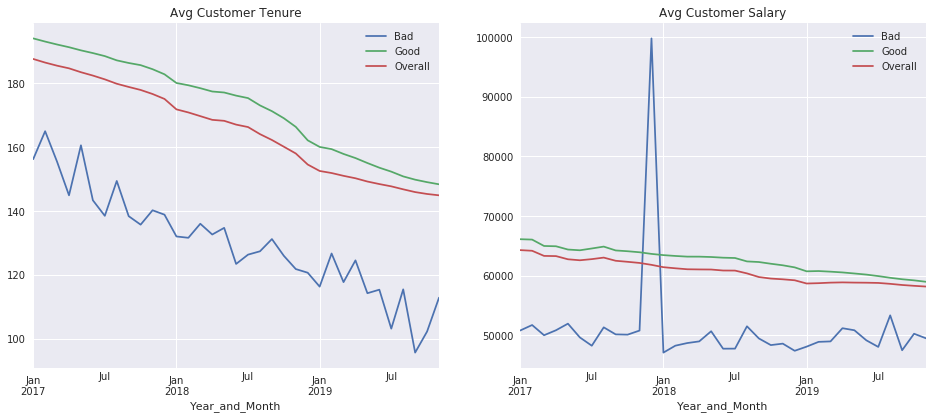

*===============================================================================================================*
						 THE HOME DEPOT
*===============================================================================================================*


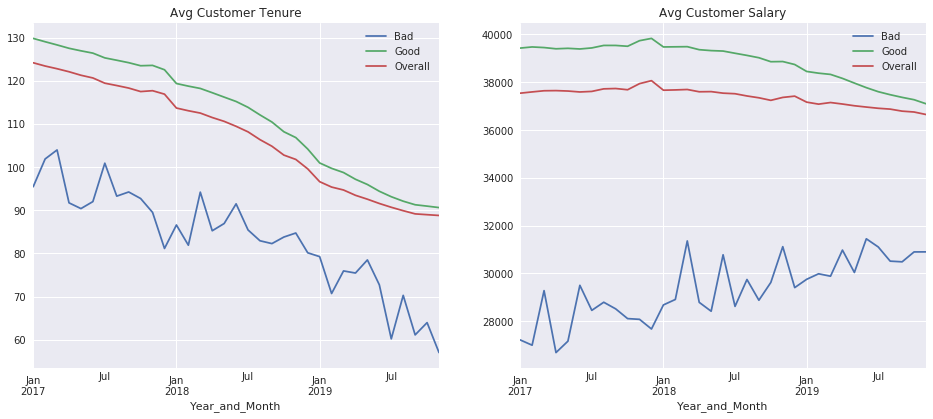

*===============================================================================================================*
						 TYSON FOODS
*===============================================================================================================*


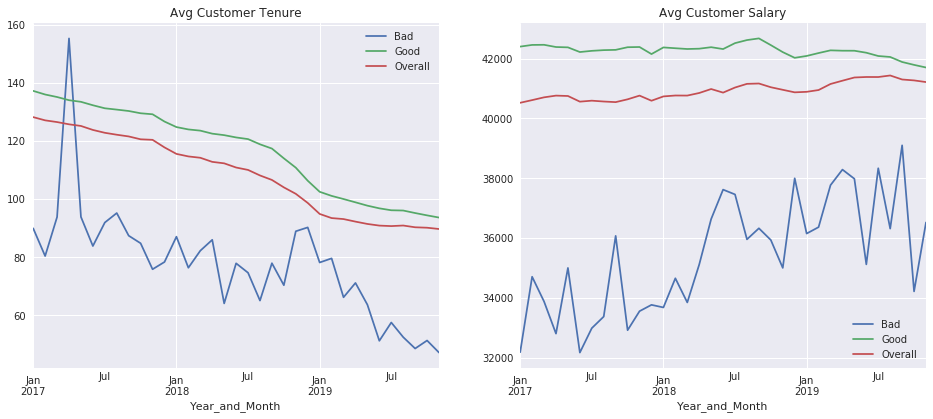

*===============================================================================================================*
						 DAVITA INC
*===============================================================================================================*


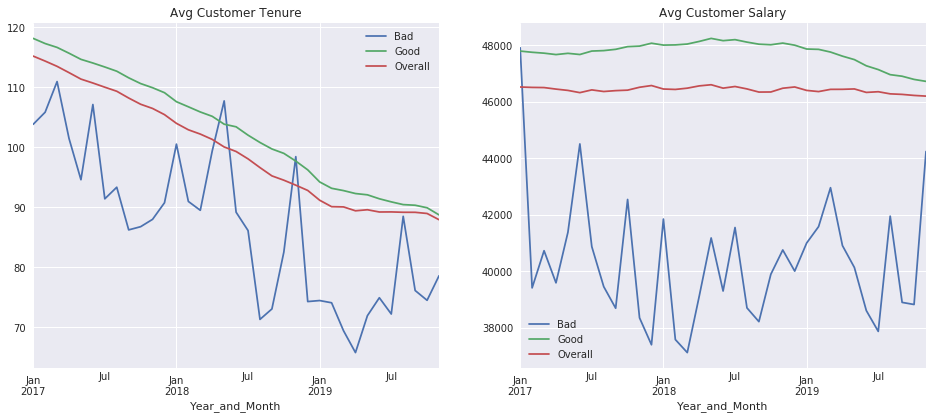

In [37]:
for client_id in [2049,2302,2149,2250]:
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize = (16,6))
    plt.subplots_adjust(left = 0.125,
                        right = 0.9,
                        bottom = 0.1,
                        top = 0.9,
                        wspace = 0.2,
                        hspace = 0.4)
    df = df_17[df_17['Unique_Company_ID']==client_id]
    df_bad = df[(df['Bad']==1) & (df['Ever_Bad']<=1)]
    df_good = df.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)
#     rest = df_17[df_17['Unique_Company_ID']!=client_id]
    acct_name = Client[Client['Client ID']==client_id]['Account Name'].values[0]
    print('*===============================================================================================================*')
    print('\t\t\t\t\t\t',acct_name)
    print('*===============================================================================================================*')

#     df_bad.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax=axes[0,0])
#     df_good.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax=axes[0,0])
#     rest.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax = axes[0,0])
#     axes[0,0].legend(['Bad','Good','Other'])
#     axes[0,0].set_title('Avg Assigned Spending Limit')


    df_bad.groupby('Year_and_Month').agg({'Tenure_at_time_of_Order':'mean'}).plot(ax=axes[0])
    df_good.groupby('Year_and_Month').agg({'Tenure_at_time_of_Order':'mean'}).plot(ax=axes[0])
    df.groupby('Year_and_Month').agg({'Tenure_at_time_of_Order':'mean'}).plot(ax=axes[0])
    
    axes[0].legend(['Bad','Good','Overall'])
    axes[0].set_title('Avg Customer Tenure')

    df_bad.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1])
    df_good.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1])
    df.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1])
    axes[1].legend(['Bad','Good','Overall'])
    axes[1].set_title('Avg Customer Salary')
    plt.show()

In [40]:
Customer.head()

,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,100001115,1000,2014-02-24,6880.0,230.0,58229.0,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
1,100001120,1000,2014-02-24,6520.0,362.0,109245.0,Repeat Buyer,94 BRENTWOOD LN,NaN,VALLEY STREAM,NY,11581,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,100001141,1000,2014-02-25,10290.0,337.0,127226.0,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
3,100001158,1000,2014-02-24,5190.0,419.0,49375.0,Repeat Buyer,1036 BRADDISH AVE,NaN,BALTIMORE,MD,21216,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
4,100001169,1000,2014-02-24,7500.0,448.0,69460.0,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA


In [ ]:
# # Annual Loss Contribution by Client
# loss_contrib = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(values='2os_loss', index='Account Name',columns='Year', aggfunc='sum',margins = True).reset_index().rename_axis(None, axis=1).iloc[:,:-1]
# # loss_contrib.iloc[:,1:] = loss_contrib.iloc[:,1:].div(loss_contrib.All, axis=0)
# loss_contrib.iloc[:,1:] = loss_contrib.iloc[:,1:].div(loss_contrib.iloc[-1,1:], axis=1)
# loss_contrib.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)
# loss_contrib = loss_contrib.iloc[:-1,:]

# loss_contrib['Avg_loss_contrib'] = loss_contrib.iloc[:,1:].mean(axis=1)
# loss_contrib['cum_loss_contrib'] = loss_contrib.sort_values('Avg_loss_contrib',ascending = False)['Avg_loss_contrib'].cumsum()
# loss_contrib = loss_contrib.merge(Client_sub[['Account Name','Client ID','Active','Termination Date']],how='left',on='Account Name')

In [ ]:
# # Annual Flow Bad Orders by Client
# flow_ord = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
#     values='Unique_Order_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# #.to_csv('../data/Client_bad_order.csv')
# flow_ord.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

# # Annual On Book $Order Amount by Client
# total_amt_ob = df_17_w_bad.groupby(['Year', 'Unique_Order_ID']).head(1).pivot_table(
#     values='Order_Amount', index='Account Name', columns='Year', aggfunc='sum').reset_index().rename_axis(None,axis=1)
# # .to_csv('../data/client_annual_ob_vol.csv')
# total_amt_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

# # Annual On Book # of Orders by Client
# total_ord_ob = df_17_w_bad.pivot_table(
#     values='Unique_Order_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# # .to_csv('../data/Client_annual_order.csv')
# total_ord_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)


In [39]:
Perf['Order_Date'].value_counts()

11/26/2018    116452
11/28/2016    114985
11/27/2017    101077
11/30/2015     93018
12/01/2014     92614
12/12/2017     85281
12/11/2018     82709
12/15/2017     82640
12/12/2016     81946
11/24/2017     81724
12/14/2017     80566
12/10/2018     80064
11/25/2016     79666
12/11/2017     78830
11/23/2018     76978
12/18/2017     76277
12/08/2015     76232
11/27/2015     75021
12/17/2017     71867
12/13/2017     71828
12/05/2017     69728
12/15/2016     68747
12/17/2018     68729
12/16/2016     67973
12/04/2017     67480
12/04/2018     66870
12/19/2017     66503
12/07/2017     66500
12/14/2015     66336
12/16/2017     66128
12/08/2014     65796
11/27/2018     65506
12/14/2018     64288
12/08/2017     63981
12/15/2015     63732
12/12/2018     63314
12/02/2013     63092
12/13/2016     62934
12/14/2016     62927
12/16/2018     62636
12/06/2016     62256
12/05/2018     62186
12/03/2018     61499
12/05/2016     60205
12/09/2016     60050
12/07/2018     59304
12/15/2018     58816
12/06/2017   

In [ ]:
def vintage_dollar_view(df, YQ, vintage):
    order_list = vintage[vintage['YQ'] == YQ]['Unique_Order_ID'].unique()
    total_balance = vintage[vintage['YQ'] == YQ]['Current_Balance'].sum()
    df_YQ = df[df['Unique_Order_ID'].isin(order_list)]
    df_DQ = df_YQ[df_YQ.Default_Status.isin(['151+', 'Chargeoff'])]
    df_DQ = df_DQ.loc[df_DQ.groupby('Unique_Order_ID')[
        'Year_and_Month'].idxmin()]
    view = df_DQ.groupby('Year_and_Month').agg({'Current_Balance':'sum'}).reset_index()
    temp = pd.DataFrame({'month_order': np.arange(1, 31), 'Year_and_Month': np.array(
        pd.date_range(start=YQ.to_timestamp(), periods=30, freq='MS'))})
    view = temp.merge(view, how = 'left',on='Year_and_Month')
    view = view.fillna(0)
    
    view['DQ_Balance'] = view['Current_Balance'].cumsum()
    view['DQ_Rate'] = view['DQ_Balance']/total_balance

#     view['month_order'] = np.arange(1+round((view['Year_and_Month'].min()-df_YQ['Year_and_Month'].min())/np.timedelta64(1, 'M')), len(
#         view)+1+round((view['Year_and_Month'].min()-df_YQ['Year_and_Month'].min())/np.timedelta64(1, 'M')))
    view.rename(columns = {'DQ_Rate':str(YQ)+'_Vintage'},inplace = True)
    return view